In [89]:
import pandas as pd
import numpy as np
import plotnine
from plotnine import *

filepath = '/Users/Allegra/Documents/Postdoc/habitus/'

# Getting the Manobi data

I have access to the following data:

- SENEGAL (multiple regions but I focus on St Louis):
    - 2015-2016:
        - Village group (parent of Village)
        - Village (parent of Farmer)
        - Farmer (parent of Plot)
        - Plot (parent of Season)
        - Season 
    - 2018-2019 (ranked by worthwhileness where 0 is not at all):
        - Buyers (0): Almost no info
        - Financers (0): Empty
        - Village group: Some info, mostly invalidated (2)
        - Village (2)
        - Farmer (parent of Plot) (?? need to check)
        - Plot (parent of FS, Harvest, Yield and Next Season): Size, soil quality (1)
        - "Fiche suivi 1, 2, & 3": Yikes! what are these?!
            - 1 appears to have management information like fertilizer and herbicide application (2)
            - 2 appears to be checking the grain maturation stage, weed status (?!) and phytosanitary treatment (?!??!) (1)
            - 3 appears to be a repetition of the above (1)
        - Harvest: Sack quantity, harvest date and harvest method (2)
        - Yield: Some yield information, not sure how this differs qualitatively from harvest (2)
        - Next season: This looks most like "Agricultural season" from 2017 (2)
    - 2019-2020:
        - Buyers: Just 2 (0)
        - Financers: Empty (0)
        - Groupe: Main crop, name, location, number of members and how many are women (2)
        - Village: Tiny (2)
        - Plot (child of Farmer): Tiny (1)
        - Season (child of Plot): Tiny; credit info, crop choice (1)
        - Season Monitoring (child of Season): Not very useful, most variables are free-answer (0)
        - Soil preparation (child of Season Monitoring): Tiny; labor and method (0)
        - Sowing (Fr: Semis) (child of Season Monitoring): Tiny; seed info (1)
        - Fertilization (child of Season Monitoring): Amount, type and price of fertilizer (1)
        - Harvest: Too small to bother; method and operator, no other info (0)
        - Postharvest (child of Season Monitoring): Tiny; Harvest weight and price (1)

- GHANA:
    - 2017:
        - Drying area
        - Village
        - Farmer
        - Plot
        - Season
    - 2020: 
        - Drying area
        - Village
        - Farmer
        - Plot
        - Agricultural season
        - Land preparation
        - Sowing
        - In-season crop monitoring
        - Fertilization
        - Plant protection
        - Harvest
        - Postharvest
        - Livestock

If I remember correctly from the last time I investigated this data, Senegal has good farmer overlap for seasons, but demographic data is not updated each year and the data structure and cleanliness is lacking. Ghana data are cleaner, in English and better organized, but there is no farmer overlap between years.

I decided to put my efforts towards the 2016 dataset because it is the biggest. Paul has already cleaned the Farmer file with the demographic information, so I will focus on the Season file. The Plot and Village/Group files have very little information. I'll return to them once I have the seasonal data available for the predictions team. I followed these steps to get the data (I'd done this before but without access to the survey structure):

1. Download data from JotBi.
2. Convert file from .xls to .xlsx
3. Remove PII, which I defined as: Agent and farmer name, phone number, specific location of farm
4. Rename the columns so they mean something
    - A note about seasons: In the earlier data sheets, "last" season and "next" season are in the same sheet. I assigned "last" season variable names with "\_season1" and "next" season variable names with "\_season2". THIS IS A TEMPORARY, TERRIBLE MEASURE. Please do not read into these at all.
5. Create a KEY for the column names which I transcribed by hand from JotBi
6. Convert French to English and remove special characters (NOTE: I wrote a little Python program to help do this by hand. I tried using a Google translate plugin but it didn't work well.)

Some touch-ups are needed:
- Deal with the "other" columns -- there are often secondary or "other" options for when the drop-down menu doesn't contain the respondent's answer.
- When I translated stuff, I didn't judge if it made sense. If you see "tractor" in the "crop_grown" column, that isn't bad translation, it's bad collection. Is "mechanized" different than "motorized"? Who knows!

In [ ]:
# Three problem spheres:
#   Column names - q's are different across surveys, and it's not always clear how to deal with season/date
#   Entries - attaching correct information to correct farmer/plot/etc ID
#   Cleaning - data aren't sensible

# Set sub-farmer dataframes' indices to be their parent ID and join iteratively

# Pluck out common columns for all dataframes - 
#       NEED DATA STRUCTURES --> what are the question texts?! Don't want to do this manually!!!

# "Season"

The issue with assigning a variable a "season" is that you never know what season you're in when an agent arrives. The only things Manobi collects are: The date the agent arrives, whether they're talking about "this" or "next" season, and the date of the event that's being asked about. It's also not clear whether, when discussing "next" season, events have already happened or are being planned for. (Note for future collection: We need to specify this.)

I think the best solution is, rather than having variables like "fertilizer_season1" and "fertilizer_season2", we should have a "fertilizer" column and a "season" column. But first I need to determine whether the labels provided by Manobi are reliable, i.e. the variables we think are Season 1 all fall within the same season.

In [94]:
df = pd.read_excel(filepath + 'data/senegal_0520/season_StLouis_2016_english.xlsx', engine = 'openpyxl')
df.head()

,ID,plot_ID,validation,collection_date,farmed_season1,plot_number_season1,crop_grown_season1,secondary_crop_grown_season1,reason_for_crop_season1,production_season1,...,credit_amount_demanded_season2,credit_amount_received_season2,credit_source_season2,interest_rate_season2,farmed_dry_season,crop_grown_dry_season,fertilizer_type_dry_season,irrigation_method_dry_season,irrigation_cost_dry_season,irrigation_source_dry_season
0,3469,3568,validated,2016-08-27 02:39:07,yes,3,irrigated_rice,NaN,all_three,12800.00,...,0,0,NaN,0%,no,NaN,NaN,NaN,0,NaN
1,3627,3723,validated,2016-10-28 08:28:37,no,NaN,NaN,NaN,NaN,0.00,...,0,0,NaN,0%,no,NaN,NaN,NaN,0,NaN
2,3642,3750,validated,2016-08-30 00:26:18,yes,3,irrigated_rice,NaN,subsistence,11.05,...,350000,350000,bank,7%,yes,irrigated_rice,NPK/Urea,Bassin/Submersion,71000,river
3,3644,3752,validated,2016-08-29 22:24:11,yes,6,irrigated_rice,NaN,subsistence,42.00,...,350000,350000,bank,7%,yes,irrigated_rice,DAP/Urea,NaN,71000,river
4,3645,3753,validated,2016-08-29 15:17:24,yes,5,irrigated_rice,NaN,subsistence,40.00,...,350000,350000,bank,7%,yes,irrigated_rice,NPK/Urea,Bassin/Submersion,81000,river


In [95]:
for clmn in df.columns:
    if 'date' in clmn:
        df[clmn].replace({'0000-00-00': np.nan}, inplace = True)
        df[clmn] = pd.to_datetime(df[clmn])
        df[clmn] = df[clmn].dt.date
        df[clmn].replace({pd.NaT: np.nan}, inplace = True)
        

Let's compare the sowing dates for "season 1" and "season 2" of 2016, known in the Manobi survey as "last" and "this/the coming" season. Note that there are some obvious typos (years in the 2020s for example) so for plotting purposes I drop dates that occur after 2017. Green shows "season 1" sowing dates, blue shows "season 2" sowing dates and red shows the date the agent went to collect data. 

NaN for season 1:  342
NaN for season 2:  2368


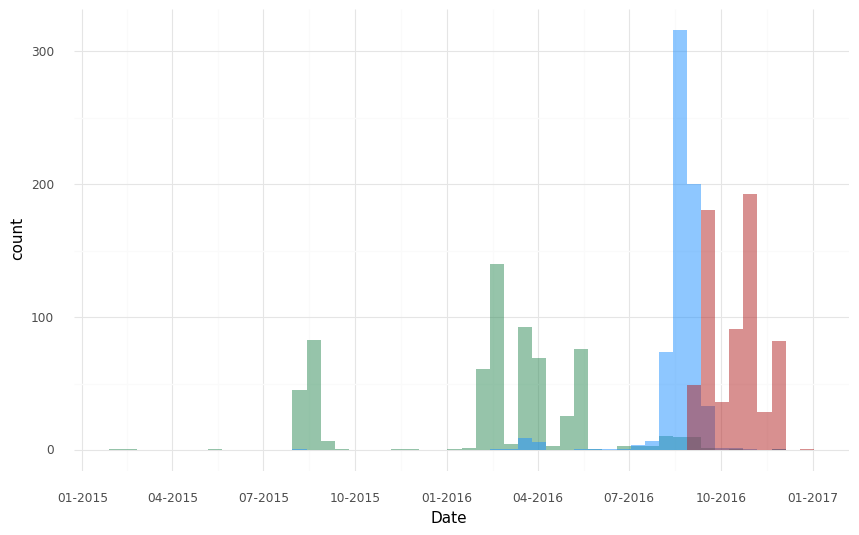

<ggplot: (316277601)>

In [117]:
sowing_df = pd.DataFrame({'season_1': df.sowing_date_season1, 'season_2': df.sowing_date_season2, 'collection': df.collection_date})

sowing_df = sowing_df[~(sowing_df['season_1'] > pd.to_datetime('2018-01-01'))]
sowing_df = sowing_df[~(sowing_df['season_2'] > pd.to_datetime('2018-01-01'))]
sowing_df = sowing_df[~(sowing_df['collection'] > pd.to_datetime('2018-01-01'))]

num_bins = 50

print("NaN for season 1: ", df.sowing_date_season1.isna().sum())
print("NaN for season 2: ", df.sowing_date_season2.isna().sum())

ggplot(sowing_df.dropna()) + geom_histogram(aes('season_1'), bins = num_bins, fill = 'seagreen', alpha = 0.5) + geom_histogram(aes('season_2'), bins = num_bins, fill = 'dodgerblue', alpha = 0.5) + geom_histogram(aes('collection'), bins = num_bins, fill = 'firebrick', alpha = 0.5) + theme_minimal() + scale_x_date(date_labels = "%m-%Y") + xlab("Date")


Here we see that all data were collected between fall of 2016 and early 2017 (red). "This" or "the coming" season, as it's referred to in the Manobi database, or "season 2" as I've been calling it, falls mostly in between August and October of 2016. According to Vijay this puts us in the wet season, although noting that these are sowing dates, we can see that some people were late sowing. We also see sowing between January and June, which according to Vijay is the dry season. But we also see the following issues:

- Season 1 is split between fall of 2015, spring of 2016 and fall of 2016. Obviously, the agents and the farmers are not always talking about the same season. The same goes for Season 2 which is split between a smattering of answers about spring 2016 and answers about fall of 2016.

- We have much more coherent information about the most recent sowing than the dry season sowing. Is this because more people sow in the wet season or because they remember what they did better? Or, is it because at the time of collection, only the people who had sowed had sowed (trivial)? Or, is it because if you're going to sow for the wet season, you do it at a specific time or not at all?

Judgment call: What do we do with seasonal information that's "out of season"? Do we assume that it was corrected months later and might be wrong now, or do we just label it with the right "season"?

There are no other dates that have information for both season 1 and 2, but we can look at the harvest and selling dates for season 1, as well as the dates of fertilization and first rainfall for season 2.

In [113]:
hd1_df = pd.DataFrame({'date': df.harvest_date_season1, 'event': 'harvest season 1'})
sd1_df = pd.DataFrame({'date': df.selling_date_season1, 'event': 'selling season 1'})
rf2_df = pd.DataFrame({'date': df.first_rainfall_date_season2, 'event': 'first rainfall season 2'})
f12_df = pd.DataFrame({'date': df.fertilizer1_date_season2, 'event': 'first fertilizer season 2'})
f22_df = pd.DataFrame({'date': df.fertilizer2_date_season2, 'event': 'second fertilizer season 2'})

date_df = pd.concat([hd1_df, sd1_df, rf2_df, f12_df, f22_df])

date_df = date_df[~(date_df['date'] > pd.to_datetime('2019-01-01'))]
date_df = date_df[~(date_df['date'] < pd.to_datetime('2015-01-01'))]

num_bins = 50
alpha_num = 0.5

plotnine.options.figure_size = (10,6)

p1 = ggplot() + geom_histogram(date_df[date_df.event == "harvest season 1"].dropna(), aes('date'), fill = 'firebrick', bins = num_bins, alpha = alpha_num) + geom_histogram(date_df[date_df.event == "selling season 1"].dropna(), aes('date'), bins = num_bins, fill = 'goldenrod', alpha = alpha_num) + theme_minimal() + scale_x_date(date_labels = "%m-%Y") + xlab("Date") 
p2 = ggplot() + geom_histogram(date_df[date_df.event == "first rainfall season 2"].dropna(), aes('date'), bins = num_bins, fill = 'seagreen', alpha = alpha_num) + geom_histogram(date_df[date_df.event == "first fertilizer season 2"].dropna(), aes('date'), bins = num_bins,  fill = 'dodgerblue', alpha = alpha_num) + geom_histogram(date_df[date_df.event == "second fertilizer season 2"].dropna(), aes('date'), bins = num_bins, fill = 'magenta', alpha = alpha_num) + theme_minimal() + scale_x_date(date_labels = "%m-%Y") + xlab("Date")

p3 = ggplot() + geom_histogram(date_df[date_df.event == "harvest season 1"].dropna(), aes('date'), fill = 'firebrick', bins = num_bins, alpha = alpha_num) + geom_histogram(date_df[date_df.event == "selling season 1"].dropna(), aes('date'), bins = num_bins, fill = 'goldenrod', alpha = alpha_num) +geom_histogram(date_df[date_df.event == "first rainfall season 2"].dropna(), aes('date'), bins = num_bins, fill = 'seagreen', alpha = alpha_num) + geom_histogram(date_df[date_df.event == "first fertilizer season 2"].dropna(), aes('date'), bins = num_bins,  fill = 'dodgerblue', alpha = alpha_num) + geom_histogram(date_df[date_df.event == "second fertilizer season 2"].dropna(), aes('date'), bins = num_bins, fill = 'magenta', alpha = alpha_num) + theme_minimal() + scale_x_date(date_labels = "%m-%Y") + xlab("Date")

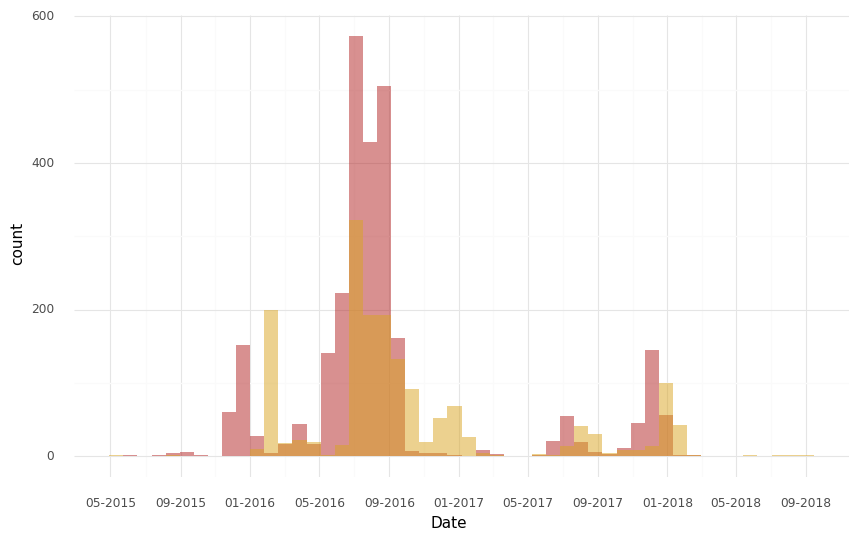

<ggplot: (316278601)> 

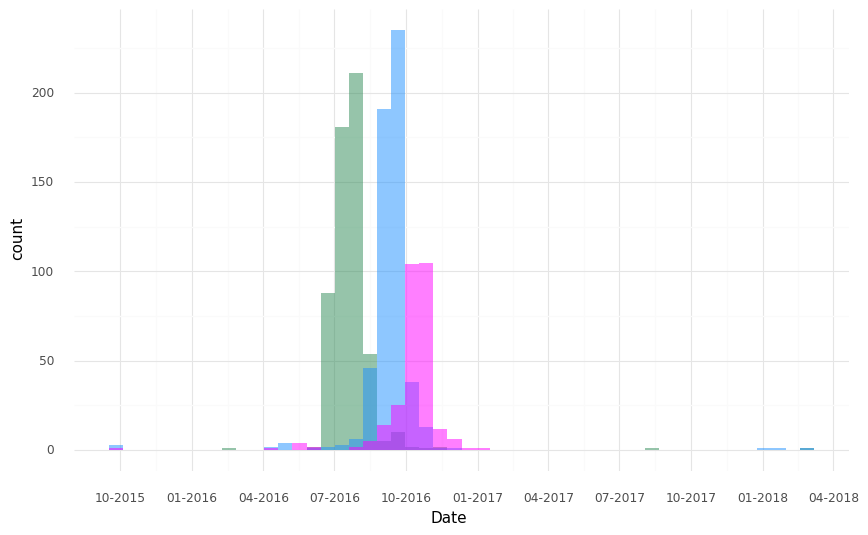

<ggplot: (316278824)>


In [115]:
print(p1,p2)

Looking at the events reported to happen in season 1 and 2, we see that harvest (red) occurs most between May and September of 2016, with another harvest occuring in fall/winter of 2017-2018. Selling (yellow) follows harvest.  Again, these are ALL events reported to be associated with "season 1/last season". For events reported to occur in "season 2/this/coming season", we see that first rainfall (green), first fertilizer application (blue) and second fertilizer application (purple) all occur within a few months of each other in 2016.

These plots tell me that there are reasonable trends to events (harvest --> selling; rain --> fertilizing) but that it's totally unclear what season the agents and farmers are discussing.

# How to arrange the data

I think one thing we can agree on is that our data ought to come with metadata similar to the way Paul arranged the CGAP data. That way, any column can be tagged with question text, answer text, units, and event type ("pre-planting", "sowing", "management", etc.). Then, I think it makes sense to organize the data this way:

| Farmer ID | Plot ID | Collection date | Assigned season | Sowing_date | Sowing_seed_variety | ... | Fertilizer_type| ...|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 4-20-2021 | 1 | 03-02-2021 | certified | ... | NPK | ... |
| ... | ... | ... | ... | ... | ... | ... | ... | ... |

where we assign seasons to rows based on the dates associated with the row. For example, suppose we have rows that mostly have sowing in fall 2016 and harvesting in 2017 -- that's clearly a season. (I'll touch on how we might do this in a second.)

I think it also makes sense to organize columns the way the CGAP data does. For example, CGAP would record a multi-category question about crop payment as three different columns "payment_market", "payment_farmgate", "payment_merchant". Suppose three pieces of information are collected about sowing: Date, seed variety, and seed amount. Then we would have three columns: "sowing_date", "sowing_seed_variety" and "sowing_seed_amount", each of which have metadata about the question, answer, units, and event ("sowing"). 

Another option would be to have an event column: 

| Farmer ID | Plot ID | Collection date | Assigned season | Event | Seed type | Fertilizer type |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 4-20-2021 | 1 | sowing | certified | NaN |
| ... | ... | ... | ... | ... | ... | ... |
| 1 | 1 | 4-20-2021 | 1 | fertilizing | NaN | NPK |

but then I don't see how we would deal with the different columns required of different events, other than creating separate databases for events linked by farmer and season ID, and that seems overly complicated.

## Finding seasons

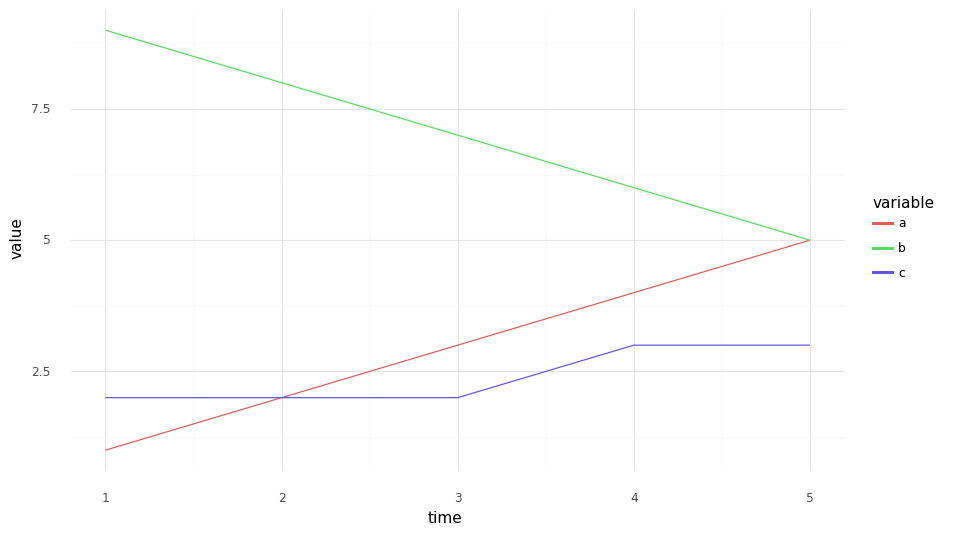

<ggplot: (316249206)>

In [130]:
# Do it a complex way:
# Rules: The earliest event and the latest event in a dataset define the range of seasons
#        Cluster dates to define seasons
#        Manually define event-columns
#        Assign season using ranges of clusters
#        Flag rows that include more than two seasons in the earliest/latest event (i.e. something may have been misrecorded)
